# Cleaning Data in Python
Run the hidden code cell below to import the data used in this course.

In [1]:
# Import the course packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import missingno as msno
import fuzzywuzzy
import recordlinkage
from datetime import datetime, timedelta

# Import the course datasets
ride_sharing = pd.read_csv('datasets/ride_sharing_new.csv', index_col = 'Unnamed: 0')
airlines = pd.read_csv('datasets/airlines_final.csv',  index_col = 'Unnamed: 0')
banking = pd.read_csv('datasets/banking_dirty.csv', index_col = 'Unnamed: 0')
restaurants = pd.read_csv('datasets/restaurants_L2.csv', index_col = 'Unnamed: 0')
restaurants_new = pd.read_csv('datasets/restaurants_L2_dirty.csv', index_col = 'Unnamed: 0')


data = {
    'cleanliness': ['Clean', 'Average', 'Somewhat clean', 'Somewhat dirty', 'Dirty'],
    'safety': ['Neutral', 'Very safe', 'Somewhat safe', 'Very unsafe', 'Somewhat unsafe'],
    'satisfaction': ['Very satisfied', 'Neutral', 'Somewhat satisfied', 'Somewhat unsatisfied', 'Very unsatisfied']
}

categories = pd.DataFrame(data)

In [22]:
print(ride_sharing)

         duration  station_A_id  ... user_birth_year  user_gender
0      12 minutes            81  ...            1959         Male
1      24 minutes             3  ...            1965         Male
2       8 minutes            67  ...            1993         Male
3       4 minutes            16  ...            1979         Male
4      11 minutes            22  ...            1994         Male
...           ...           ...  ...             ...          ...
25755  11 minutes            15  ...            2000         Male
25756  10 minutes            15  ...            1998         Male
25757  14 minutes            15  ...            1995         Male
25758  14 minutes            15  ...            1995         Male
25759  29 minutes            16  ...            1990         Male

[25760 rows x 9 columns]


In [23]:
print(ride_sharing.columns)

Index(['duration', 'station_A_id', 'station_A_name', 'station_B_id',
       'station_B_name', 'bike_id', 'user_type', 'user_birth_year',
       'user_gender'],
      dtype='object')


## Explore Datasets
Use the DataFrames imported in the first cell to explore the data and practice your skills!
- For each DataFrame, inspect the data types of each column and, where needed, clean and convert columns into the correct data type. You should also rename any columns to have more descriptive titles.
- Identify and remove all the duplicate rows in `ride_sharing`.
- Inspect the unique values of all the columns in `airlines` and clean any inconsistencies.
- For the `airlines` DataFrame, create a new column called `International` from `dest_region`, where values representing US regions map to `False` and all other regions map to `True`.
- The `banking` DataFrame contains out of date ages. Update the `Age` column using today's date and the `birth_date` column.
- Clean the `restaurants_new` DataFrame so that it better matches the categories in the `city` and `type` column of the `restaurants` DataFrame. Afterward, given typos in restaurant names, use record linkage to generate possible pairs of rows between `restaurants` and `restaurants_new` using criteria you think is best.


# 1. Data Type constraints

### Outline -
   - we're going to understand how to diagnose different problems in our data and how they can can come up during our workflow.We will also understand the side effects of not treating our data correctly.and various ways to address different types of dirty data.In this chapter, we're going to discuss the most common data problems you may encounter and how to address them. So let's get started!
   
### Why do we need to clean data?
   - To understand why we need to clean data, let's remind ourselves of the data science workflow. In a typical data science workflow, we usually access our raw data, explore and process it, develop insights using visualizations or predictive models, and finally report these insights with dashboards or reports.Dirty data can appear because of duplicate values, mis-spellings, data type parsing errors and legacy systems.Without making sure that data is properly cleaned in the exploration and processing phase, we will surely compromise the insights and reports subsequently generated. As the old adage says, garbage in garbage out.

![why need to clean data](why%20need%20to%20clean%20data.PNG)

### Data type constraints -
   - When working with data, there are various types that we may encounter along the way. We could be working with text data, integers, decimals, dates, zip codes, and others. Luckily, Python has specific data type objects for various data types that you're probably familiar with by now. This makes it much easier to manipulate these various data types in Python. As such, before preparing to analyze and extract insights from our data, we need to make sure our variables have the correct data types, other wise we risk compromising our analysis.

When working with new data, you should always check the data types of your columns using the .dtypes attribute or the .info() method which you'll see in the next exercise. Often times, you'll run into columns that should be converted to different data types before starting any analysis.

The `user_type` column contains information on whether a user is taking a free ride and takes on the following values:

1.  for free riders.
2.  for pay per ride.
3.  for monthly subscribers.

In this instance, you will print the information of ride_sharing using `.info()` and see a firsthand example of how an incorrect data type can flaw your analysis of the dataset.

In [24]:
print(ride_sharing.info())

print(ride_sharing['user_type'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25760 entries, 0 to 25759
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   duration         25760 non-null  object
 1   station_A_id     25760 non-null  int64 
 2   station_A_name   25760 non-null  object
 3   station_B_id     25760 non-null  int64 
 4   station_B_name   25760 non-null  object
 5   bike_id          25760 non-null  int64 
 6   user_type        25760 non-null  int64 
 7   user_birth_year  25760 non-null  int64 
 8   user_gender      25760 non-null  object
dtypes: int64(5), object(4)
memory usage: 2.0+ MB
None
count    25760.000000
mean         2.008385
std          0.704541
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          3.000000
Name: user_type, dtype: float64


### ??
**By looking at the summary statistics - they don't really seem to offer much description on how users are distributed along their purchase type, why do you think that is?**

Possible answers-

1. The `user_type` column is not of the correct type, it should be converted to str.
2. The `user_type` column has an infinite set of possible values, it should be converted to category.
3. The `user_type` column has an finite set of possible values that represent groupings of data, it should be converted to category.

Ans - 3.

### Summing strings and concatenating numbers
we were able to identify that category is the correct data type for `user_type` and convert it in order to extract relevant statistical summaries that shed light on the distribution of `user_type`.In this exercise, you'll be converting the string column duration to the type int. Before that however, you will need to make sure to strip "minutes" from the column in order to make sure pandas reads it as numerical.

In [25]:
print(ride_sharing[["duration"]])

         duration
0      12 minutes
1      24 minutes
2       8 minutes
3       4 minutes
4      11 minutes
...           ...
25755  11 minutes
25756  10 minutes
25757  14 minutes
25758  14 minutes
25759  29 minutes

[25760 rows x 1 columns]


In [26]:
ride_sharing['duration_trim'] = ride_sharing['duration'].str.strip('minutes')

ride_sharing['duration_time'] = ride_sharing['duration_trim'].astype('int')

assert ride_sharing['duration_time'].dtype == 'int'

print(ride_sharing[['duration','duration_trim','duration_time']])
print(ride_sharing['duration_time'].mean())

         duration duration_trim  duration_time
0      12 minutes           12              12
1      24 minutes           24              24
2       8 minutes            8               8
3       4 minutes            4               4
4      11 minutes           11              11
...           ...           ...            ...
25755  11 minutes           11              11
25756  10 minutes           10              10
25757  14 minutes           14              14
25758  14 minutes           14              14
25759  29 minutes           29              29

[25760 rows x 3 columns]
11.389052795031056


### Data range constraints

we're going to discuss data that should fall within a range.After creating a histogram with maptlotlib, we see that there are a few movies with an average rating of 6, which is well above the allowable range. This is most likely an error in data collection or parsing, where a variable is well beyond its range and treating it is essential to have accurate analysis.

### How to deal with out of range data?

There's a variety of options to deal with out of range data. The simplest option is to drop the data. However, depending on the size of your out of range data, you could be losing out on essential information. As a rule of thumb, only drop data when a small proportion of your dataset is affected by out of range values, however you really need to understand your dataset before deciding to drop values. Another option would be setting custom minimums or maximums to your columns. We could also set the data to missing, and impute it, but we'll take a look at how to deal with missing data in Chapter 3. We could also, dependent on the business assumptions behind our data, assign a custom value for any values of our data that go beyond a certain range.

Bicycle tire sizes could be either 26″, 27″ or 29″ and are here correctly stored as a categorical value. In an effort to cut maintenance costs, the ride sharing provider decided to set the maximum tire size to be 27″.

In this exercise, you will make sure the `tire_sizes` column has the correct range by first converting it to an integer, then setting and testing the new upper limit of 27″ for tire sizes.

### Add `tire_sizes` columns

In [27]:
np.random.seed(0)
ride_sharing['tire_sizes'] = np.random.choice(['26', '27', '29'], size=len(ride_sharing))

In [28]:
# Convert tire_sizes to integer
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('int')

# Set all values above 27 to 27
ride_sharing.loc[ride_sharing['tire_sizes'] > 27, 'tire_sizes'] = 27

# Reconvert tire_sizes back to categorical
ride_sharing['tire_sizes'] = ride_sharing['tire_sizes'].astype('category')

# Print tire size description
print(ride_sharing['tire_sizes'].describe())

count     25760
unique        2
top          27
freq      17170
Name: tire_sizes, dtype: int64


### Add column `ride_date`

In [29]:
np.random.seed(0)

# Number of rows in the DataFrame
total_rows = 25760

# 70% past dates, 20% today, and 10% future dates
past_rows = int(total_rows * 0.7)
today_rows = int(total_rows * 0.2)
future_rows = total_rows - past_rows - today_rows  # The remaining rows will be future dates

# Generate random past dates (within the past year)
past_dates = [datetime.today() - timedelta(days=np.random.randint(1, 365)) for _ in range(past_rows)]

# Generate today's date for the 20% of the rows
today_dates = [datetime.today() for _ in range(today_rows)]

# Generate random future dates (within the next year)
future_dates = [datetime.today() + timedelta(days=np.random.randint(1, 365)) for _ in range(future_rows)]

# Combine all the dates
ride_dates = past_dates + today_dates + future_dates

# Shuffle the dates to mix them randomly
np.random.shuffle(ride_dates)

# Add the 'ride_date' column to the DataFrame
ride_sharing['ride_date'] = ride_dates

### Timedelta

In [30]:
# what is the output of -
timedelta(days=np.random.randint(1, 365))

datetime.timedelta(days=46)

The `randint` function is a part of the numpy.random module (or the random module in Python) that generates a random integer within a specified range.

In [31]:
print(ride_sharing['ride_date'].dtypes)

datetime64[ns]


### Back to the future

In [32]:
# Convert ride_date to date
ride_sharing['ride_dt'] = pd.to_datetime(ride_sharing['ride_date']).dt.date

# Save today's date
today = dt.date.today()

# Set all in the future to today's date
ride_sharing.loc[ride_sharing['ride_dt'] > today, 'ride_dt'] = today

# Print maximum of ride_dt column
print(ride_sharing['ride_dt'].max())

2025-04-05


In [33]:
print(ride_sharing['ride_dt'].dtypes)

object


### Uniqueness constraints

### What are duplicate values?

   - Duplicate values can be diagnosed when we have the same exact information repeated across multiple rows, for a some or all columns in our DataFrame.

### Why they happend?

![why they happed](why%20they%20happed.PNG)

### How to find duplicate rows?

A new update to the data pipeline feeding into `ride_sharing` has added the `ride_id` column, which represents a unique identifier for each ride.

The update however coincided with radically shorter average ride duration times and irregular user birth dates set in the future. Most importantly, the number of rides taken has increased by 20% overnight, leading you to think there might be both complete and incomplete duplicates in the ride_sharing DataFrame.

### Finding duplicates

In [34]:
# Step 1: Create unique IDs for all rows
total_rows = len(ride_sharing)
unique_ids = np.arange(1, total_rows + 1)

# Step 2: Randomly select 20% of the IDs to make duplicates
num_duplicates = int(total_rows * 0.2)
duplicate_indices = np.random.choice(total_rows, size=num_duplicates, replace=False)

# Step 3: Create the ID column
id_column = unique_ids.copy()

# Step 4: Duplicate the IDs in the selected rows
for idx in duplicate_indices:
    # Choose a random index to duplicate the ID from
    duplicate_id = np.random.choice(unique_ids)
    id_column[idx] = duplicate_id

# Step 5: Add the 'id' column to the DataFrame
ride_sharing['ride_id'] = id_column

In [35]:
# Find duplicates
duplicates = ride_sharing.duplicated(subset = 'ride_id', keep = False)

# Sort your duplicated rides
duplicated_rides = ride_sharing[duplicates].sort_values(by = 'ride_id')

# Print relevant columns of duplicated_rides
print(duplicated_rides[['ride_id','duration','user_birth_year']])

       ride_id    duration  user_birth_year
8            9  21 minutes             1982
20293        9  11 minutes             1988
11          12   6 minutes             1990
9694        12  11 minutes             1989
17913       17   7 minutes             1966
...        ...         ...              ...
6475     25746  10 minutes             1978
19783    25756  12 minutes             1990
25755    25756  11 minutes             2000
8920     25758  13 minutes             1990
25757    25758  14 minutes             1995

[8013 rows x 3 columns]


In [36]:
np.random.choice(10, size = 7, replace = False)

array([7, 2, 4, 1, 5, 3, 0])

we were able to verify that the new update feeding into `ride_sharing` contains a bug generating both complete and incomplete duplicated rows for some values of the `ride_id` column, with occasional discrepant values for the `user_birth_year` and duration columns.

### Treating duplicates

In [40]:
# Drop complete duplicates from ride_sharing
ride_dup = ride_sharing.drop_duplicates()

# Create statistics dictionary for aggregation function
statistics = {'user_birth_year': 'min', 'duration_time': 'mean'}

# Group by ride_id and compute new statistics
ride_unique = ride_dup.groupby(by ='ride_id').agg(statistics).reset_index()

print(ride_unique)

# Find duplicated values again
duplicates = ride_unique.duplicated(subset = 'ride_id', keep = False)
print(duplicates)
duplicated_rides = ride_unique[duplicates == True]

# Assert duplicates are processed
assert duplicated_rides.shape[0] == 0

       ride_id  user_birth_year  duration_time
0            1             1959           12.0
1            3             1993            8.0
2            4             1979            4.0
3            5             1994           11.0
4            6             1979           10.0
...        ...              ...            ...
21566    25755             1989            9.0
21567    25756             1990           11.5
21568    25758             1990           13.5
21569    25759             1995           14.0
21570    25760             1990           29.0

[21571 rows x 3 columns]
0        False
1        False
2        False
3        False
4        False
         ...  
21566    False
21567    False
21568    False
21569    False
21570    False
Length: 21571, dtype: bool


**Ride sharing KPIs will come back to normal**

# 2. Membership Constrain

In this chapter, we're going to take a look at common data problems with text and categorical data, so let's get started.

## Categories and Membership Constrains
we'll focus on categorical variables. As discussed early in chapter 1, categorical data represent variables that represent predefined finite set of categories. Examples of this range from marriage status, household income categories, loan status and others. To run machine learning models on categorical data, they are often coded as numbers. Since categorical data represent a predefined set of categories, they can't have values that go beyond these predefined categories.

![image](image.png)

### Members only
Throughout the course so far, you've been exposed to some common problems that you may encounter with your data, from data type constraints, data range constraints, uniqueness constraints, and now membership constraints for categorical values.

In this exercise, you will find out which one is `Membership categories` and which one is `Other Categories.`

- A `revenue` column represnted as a string
- A `has_loan` column with the value 12
- A `day_of_week` column with the value `Suntermonday`
- A `GPA` containing a `Z-` grade
- An `age` column with values above `130`
- A `birthday` columns with values in the futures

## Why could we have this problem?
- Data Entry Error
    - Free text
    - Dropdowns
- Parsing Error

## How do we treat these problems?
- Dropping Data
- Remapping Categories
- Inferring Categories

## An Example
- Luckily, the categories DataFrame will help us systematically spot all rows with these inconsistencies. It's always good practice to keep a log of all possible values of your categorical data, as it will make dealing with these types of inconsistencies way easier.

In this exercise, you will use both of these DataFrames to find survey answers with inconsistent values, and drop them, effectively performing an outer and inner join on both these DataFrames as seen in the video exercise.

In [2]:
# Print categories DataFrame
print(categories)

# Print unique values of survey columns in airlines
print('Cleanliness: ', airlines['cleanliness'].unique(), "\n")
print('Safety: ', airlines['safety'].unique(), "\n")
print('Satisfaction: ', airlines['satisfaction'].unique(), "\n")

      cleanliness           safety          satisfaction
0           Clean          Neutral        Very satisfied
1         Average        Very safe               Neutral
2  Somewhat clean    Somewhat safe    Somewhat satisfied
3  Somewhat dirty      Very unsafe  Somewhat unsatisfied
4           Dirty  Somewhat unsafe      Very unsatisfied
Cleanliness:  ['Clean' 'Average' 'Somewhat clean' 'Somewhat dirty' 'Dirty'] 

Safety:  ['Neutral' 'Very safe' 'Somewhat safe' 'Very unsafe' 'Somewhat unsafe'] 

Satisfaction:  ['Very satisfied' 'Neutral' 'Somewhat satsified' 'Somewhat unsatisfied'
 'Very unsatisfied'] 



## Q: Take a look at the output. Out of the `cleanliness`, `safety` and `satisfaction` columns, which one has an inconsistent category and what is it?

Possible answers

- `cleanliness` because it has an Unacceptable category.
- 
- `cleanliness` because it has a Terribly dirty category.
- 
- `satisfaction` because it has a Very satisfied category.
- 
- `safety` because it has a Neutral category.

## Dropping Inconsistance Categories -

In [3]:
# Find the cleanliness category in airlines not in categories
cat_clean = set(airlines['cleanliness']).difference(categories['cleanliness'])

# Find rows with that category
cat_clean_rows = airlines['cleanliness'].isin(cat_clean)

inconsistent_cat = airlines[cat_clean_rows]

# Print rows with inconsistent category
print(inconsistent_cat)

Empty DataFrame
Columns: [id, day, airline, destination, dest_region, dest_size, boarding_area, dept_time, wait_min, cleanliness, safety, satisfaction]
Index: []


Since the dataframe they provied is cleaned. So we get `Empty DataFram`, for convinience i am add the output what we find in the course-

![set](set.PNG)


### Print Consistent category

In [ ]:
print(airlines[~cat_clean_raw])

## A note on joins
Now before moving on to dealing with these inconsistent values, let's have a brief reminder on joins. The two main types of joins we care about here are anti joins and inner joins. We join DataFrames on common columns between them. Anti joins, take in two DataFrames A and B, and return data from one DataFrame that is not contained in another. In this example, we are performing a left anti join of A and B, and are returning the columns of DataFrames A and B for values only found in A of the common column between them being joined on. Inner joins, return only the data that is contained in both DataFrames. For example, an inner join of A and B, would return columns from both DataFrames for values only found in A and B, of the common column between them being joined on.

![join](join.PNG)


### Categorical variables
Now let's discuss other types of problems that could affect categorical variables.

What type of errors could we have?
- Value inconsistency
    - Inconsistent fields: 'married' , 'Maried' , 'UNMARRIED' , 'not married' ..
    - _Trailing white spaces: _'married ' , ' married ' ..
- Collapsing too many categories to few
     - Creating new groups: 0-20K , 20-40K categories ... from continuous household income data Mapping
     - groups to new ones: Mapping household income categories to 2 'rich' , 'poor'
- Making sure data is of type `category`

## Value consistency
Let's start with making sure our categorical data is consistent. A common categorical data problem is having values that slightly differ because of capitalization. Not treating this could lead to misleading results when we decide to analyze our data, for example, let's assume we're working with a demographics dataset, and we have a marriage status column with inconsistent capitalization. Here's what counting the number of married people in the `marriage_status` Series would look like. Note that the `dot-value_counts()` methods works on Series only.

### Inconsistent categories: - 
In this exercise, we will examine two categorical columns from this DataFrame, `dest_region` and `dest_size` respectively, assess how to address them and make sure that they are cleaned and ready for analysis. 

In [3]:
# Print unique values of both columns
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['Asia' 'Canada/Mexico' 'West US' 'East US' 'Midwest US' 'EAST US'
 'Middle East' 'Europe' 'eur' 'Central/South America'
 'Australia/New Zealand' 'middle east']
['Hub' 'Small' '    Hub' 'Medium' 'Large' 'Hub     ' '    Small'
 'Medium     ' '    Medium' 'Small     ' '    Large' 'Large     ']


### Question
From looking at the output, what do you think is the problem with these columns?

**Possible answers**


- The `dest_region` column has only inconsistent values due to capitalization.

- The `dest_region` column has inconsistent values due to capitalization and has one value that needs to be remapped.
  
- The `dest_size` column has only inconsistent values due to leading and trailing spaces.
  
- Both 2 and 3 are correct.

In [4]:
# Lower dest_region column and then replace "eur" with "europe"
airlines['dest_region'] = airlines['dest_region'].str.lower()
airlines['dest_region'] = airlines['dest_region'].replace({'eur': 'europe'})
print(airlines['dest_region'].unique())

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']


### Remove white spaces from `dest_size`

In [5]:
airlines['dest_size'] = airlines['dest_size'].str.strip()
# Verify changes have been effected
print(airlines['dest_region'].unique())
print(airlines['dest_size'].unique())

['asia' 'canada/mexico' 'west us' 'east us' 'midwest us' 'middle east'
 'europe' 'central/south america' 'australia/new zealand']
['Hub' 'Small' 'Medium' 'Large']


### Remapping categories
To better understand survey respondents from `airlines`, you want to find out if there is a relationship between certain responses and the day of the week and wait time at the gate.

The `airlines` DataFrame contains the `day` and `wait_min` columns, which are categorical and numerical respectively. The `day` column contains the exact day a flight took place, and `wait_min` contains the amount of minutes it took travelers to wait at the gate. To make your analysis easier, you want to create two new categorical variables:

`wait_type`: `'short'` for 0-60 min, `'medium'` for 60-180 and `long` for 180+
`day_week`: `'weekday'` if day is in the weekday, `'weekend'` if day is in the weekend.

In [7]:
# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines['wait_type'] = pd.cut(airlines['wait_min'], bins = label_ranges, labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday','Thursday': 'weekday', 'Friday': 'weekday', 'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)
print(airlines.head())

     id        day      airline  ...        satisfaction wait_type day_week
0  1351    Tuesday  UNITED INTL  ...      Very satisfied    medium  weekday
1   373     Friday       ALASKA  ...      Very satisfied    medium  weekday
2  2820   Thursday        DELTA  ...             Neutral    medium  weekday
3  1157    Tuesday    SOUTHWEST  ...  Somewhat satsified      long  weekday
4  2992  Wednesday     AMERICAN  ...  Somewhat satsified      long  weekday

[5 rows x 14 columns]


## 2.3 Cleaning text data

Text data is one of the most common types of data types. Examples of it range from names, phone numbers, addresses, emails and more.

### Common text data problems
1. Data inconsistency:   +96171679912 or 0096171679912 or ..?
2. Fixed length violations:  Passwords needs to be at least 8 characters
3. Typos:  +961.71.679912

Suppose we have a dataframe with `phone_number`.How to cleanig `inconsistance data format`, `length violation` and any other problem to these column.following code try to solve some problem in `phone_number` column.

In [ ]:
# Replace "+" with "00"
phones["Phone number"] = phones["Phone number"].str.replace("+", "00")

# Replace "-" with nothing
phones["Phone number"] = phones["Phone number"].str.replace("-", "")

# Replace phone numbers with lower than 10 digits to NaN
digits = phones['Phone number'].str.len()
phones.loc[digits < 10, "Phone number"] = np.nan

# Find length of each row in Phone number column
sanity_check = phone['Phone number'].str.len()

# Assert minmum phone number length is 10
assert sanity_check.min() >= 10

# Assert all numbers do not have "+" or "-"
assert phone['Phone number'].str.contains("+|-").any() == False

# Remember,assert returns nothing if the condition pass.

# Replace letters with nothing
phones['Phone number'] = phones['Phone number'].str.replace(r'\D+', '')

### Removing titles and taking names

In [4]:
print(airlines.head())
print(airlines.columns)

     id        day  ...         safety        satisfaction
0  1351    Tuesday  ...        Neutral      Very satisfied
1   373     Friday  ...      Very safe      Very satisfied
2  2820   Thursday  ...  Somewhat safe             Neutral
3  1157    Tuesday  ...      Very safe  Somewhat satsified
4  2992  Wednesday  ...      Very safe  Somewhat satsified

[5 rows x 12 columns]
Index(['id', 'day', 'airline', 'destination', 'dest_region', 'dest_size',
       'boarding_area', 'dept_time', 'wait_min', 'cleanliness', 'safety',
       'satisfaction'],
      dtype='object')


The airlines dataframe have no 'Full_name' column.I think they remove this columns so that anyone not to reuse their dataframe and their content.So i will only give their code how to do "Cleaning text data".

### Removing titles and taking names
While collecting survey respondent metadata in the airlines DataFrame, the full name of respondents was saved in the full_name column. However upon closer inspection, you found that a lot of the different names are prefixed by honorifics such as `"Dr.", "Mr.", "Ms."` and `"Miss"`.

Your ultimate objective is to create two new columns named `first_name` and `last_name`, containing the first and last names of respondents respectively. Before doing so however, you need to remove honorifics.

The airlines DataFrame is in your environment, alongside pandas as pd.

- Remove `"Dr.", "Mr.", "Miss"` and `"Ms."` from full_name by replacing them with an empty string "" in that order.
- Run the assert statement using `.str.contains()` that tests whether `full_name` still contains any of the honorifics.

In [ ]:
# Replace "Dr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace('Dr.','')

# Replace "Mr." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace('Mr.','')

# Replace "Miss" with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace('Miss','')

# Replace "Ms." with empty string ""
airlines['full_name'] = airlines['full_name'].str.replace('Ms.','')

# Assert that full_name has no honorifics
assert airlines['full_name'].str.contains('Ms.|Mr.|Miss|Dr.').any() == False

### Keeping it descriptive
To further understand travelers' experiences in the San Francisco Airport, the quality assurance department sent out a qualitative questionnaire to all travelers who gave the airport the worst score on all possible categories. The objective behind this questionnaire is to identify common patterns in what travelers are saying about the airport.

Their response is stored in the `survey_response` column. Upon a closer look, you realized a few of the answers gave the shortest possible character amount without much substance. In this exercise, you will isolate the responses with a character count higher than 40 , and make sure your new DataFrame contains responses with 40 characters or more using an assert statement.

The `airlines` DataFrame is in your environment, and pandas is imported as pd.

- Using the `airlines` DataFrame, store the length of each instance in the `survey_response` column in resp_length by using `.str.len()`.
- Isolate the rows of airlines with `resp_length` higher than 40.
- Assert that the smallest `survey_response` length in airlines_survey is now bigger than 40.

In [ ]:
# Store length of each row in survey_response column
resp_length = airlines['survey_response'].str.len()

# Find rows in airlines where resp_length > 40
airlines_survey = airlines[resp_length > 40]

# Assert minimum survey_response length is > 40
assert airlines_survey['survey_response'].str.len().min() > 40

# Print new survey_response column
print(airlines_survey['survey_response'])

## 3. Advanced data problems

we're looking at more advanced data cleaning problems, such as 
- uniformity, 
- cross field validation and 
- dealing with missing data.

In chapter 1, we saw how out of range values are a common problem when cleaning data, and that when left untouched, can skew your analysis.

### 3.1 Uniformity

   In this lesson, we're going to tackle a problem that could similarly skew our data, which is unit uniformity. For example, we can have temperature data that has values in both Fahrenheit and Celsius, weight data in Kilograms and in stones, dates in multiple formats, and so on. Verifying unit uniformity is imperative to having accurate analysis.

![uniformity](uniformity.PNG)

### Example

A dataset with average temperature data throughout the month of March in New York City. The dataset was collected from different sources with temperature data in Celsius and Fahrenheit merged together. We can see that unless a major climate event occurred,this value here is most likely Fahrenheit, not Celsius.

To confirm the presence of these values visually.We can do so by plotting a scatter plot of our data. We can do this using matplotlib.

In [ ]:
temperatures = pd.read_csv('temperature.csv') 
temperatures.head()

In [ ]:
# Import matplotlib 
import matplotlib.pyplot 
as plt 
# Create scatter plot 
plt.scatter(x = 'Date', y = 'Temperature', data = temperatures) 
# Create title, xlabel and ylabel 
plt.title('Temperature in Celsius March 2019 - NYC') 
plt.xlabel('Dates') 
plt.ylabel('Temperature in Celsius')  
# Show plot 
plt.show()

![temp](temp.PNG)

the above three point we show in the plot,They all must be fahrenheit.

### Treating temperature data

A simple web search returns the formula for converting Fahrenheit to Celsius. To convert our temperature data, we isolate all rows of temperature column where it is above 40 using the loc method. We chose 40 because it's a common sense maximum for Celsius temperatures in New York City. We then convert these values to Celsius using the formula C =(F −32)×5/9, and reassign them to their respective Fahrenheit values in temperatures. We can make sure that our conversion was correct with an assert statement, by making sure the maximum value of temperature is less than 40.

In [ ]:
temp_fah = temperatures.loc[temperatures['Temperature'] > 40, 'Temperature'] 
temp_cels = (temp_fah - 32) * (5/9) 
temperatures.loc[temperatures['Temperature'] > 40, 'Temperature'] = temp_cels 
# Assert conversion is correct 
assert temperatures['Temperature'].max() < 40

### Treating date data

Here's another common uniformity problem with date data. This is a DataFrame called birthdays containing birth dates for a variety of individuals. It has been collected from a variety of sources and merged into one.

![teating date data](teating%20date%20data.PNG)

Notice the dates here? The one in blue has the month, day, year format, whereas the one in orange has the month written out. The one in red is obviously an error, with what looks like a day day year format. We'll learn how to deal with that one as well.

![data](data.PNG)


###  Datetime formatting

We already discussed datetime objects. Without getting too much into detail, datetime accepts different formats that help you format your dates as pleased. The pandas to datetime function automatically accepts most date formats, but could raise errors when certain formats are unrecognizable. You don't have to memorize these formats, just know that they exist and are easily searchable!

` pandas.to_datetime()`
-  Can recognize most formats automatically
-  Sometimes fails with erroneous or unrecognizable formats

### Treating date data

You can treat these date inconsistencies easily by converting your date column to datetime. We can do this in pandas with the to_datetime function. However this isn't enough and will most likely return an error, since we have dates in multiple formats, especially the weird day/day/format which triggers an error with months.

In [ ]:
birthdays['Birthday'] = pd.to_datetime(birthdays['Birthday']) 


ValueError: month must be in 1..12 

Instead we set the infer_datetime_format argument to True, and set errors equal to coerce. This will infer the format and return missing value for dates that couldn't be identified and converted instead of a value error.

In [ ]:
# Will work! 
birthdays['Birthday'] = pd.to_datetime(birthdays['Birthday'], 
# Attempt to infer format of each date 
infer_datetime_format=True,  
# Return NA for rows where conversion failed 
errors = 'coerce')
 
birthdays.head() 

![data2](data2.PNG)


We can also convert the format of a datetime column using the dt dot strftime method, which accepts a datetime format of your choice. For example, here we convert the Birthday column to day month year, instead of year month day.

In [ ]:
birthdays['Birthday'] = birthdays['Birthday'].dt.strftime("%d-%m-%Y") 
birthdays.head() 

![birthdayhead](birthdayhead.PNG)

However a common problem is having ambiguous dates with vague formats.

_Is 2019-03-08 in August or March?_

Unfortunately there's no clear cut way to spot this inconsistency or to treat it. Depending on the size of the dataset and suspected ambiguities, we can either convert these dates to NAs and deal with them accordingly. If you have additional context on the source of your data, you can probably infer the format. If the majority of subsequent or previous data is of one format, you can probably infer the format as well. All in all, it is essential to properly understand where your data comes from, before trying to treat it, as it will make making these decisions much easier.

### Ambiguous dates
You have a DataFrame containing a subscription_date column that was collected from various sources with different Date formats such as YYYY-mm-dd and YYYY-dd-mm. What is the best way to unify the formats for ambiguous values such as 2019-04-07?

Possible Answers - Select one answer

- Set them to NA and drop them. 
- Infer the format of the data in question by checking the format of subsequent and previous values.
- Infer the format from the original data source.
- All of the above are possible, as long as we investigate where our data comes from, and understand the dynamics affecting it before cleaning it.

### Uniform currencies
In this exercise and throughout this chapter, you will be working with a retail banking dataset stored in the `banking` DataFrame. The dataset contains data on the amount of money stored in accounts (`acct_amount`), their currency (`acct_cur`), amount invested (`inv_amount`), account opening date (`account_opened`), and last transaction date (`last_transaction`) that were consolidated from American and European branches.

You are tasked with understanding the average account size and how investments vary by the size of account, however in order to produce this analysis accurately, you first need to unify the currency amount into dollars. The `pandas` package has been imported as `pd`, and the banking DataFrame is in your environment.

- Find the rows of `acct_cur` in banking that are equal to `'euro`' and store them in the variable `acct_eu`.
- Find all the rows of acct_amount in banking that fit the `acct_eu` condition, and convert them to USD by multiplying them with 1.1.
- Find all the rows of `acct_cur` in banking that fit the `acct_eu` condition, set them to `'dollar'`.

In [ ]:
# Find values of acct_cur that are equal to 'euro'
acct_eu = banking['acct_cur'] == 'euro'

# Convert acct_amount where it is in euro to dollars
banking.loc[acct_eu, 'acct_amount'] = banking.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 'euro' values to 'dollar'
banking.loc[acct_eu, 'acct_cur'] = 'dollar'

# Assert that only dollar currency remains
assert banking['acct_cur'].unique() == 'dollar'

### Uniform dates
After having unified the currencies of your different account amounts, you want to add a temporal dimension to your analysis and see how customers have been investing their money given the size of their account over each year. The `account_opened` column represents when customers opened their accounts and is a good proxy for segmenting customer activity and investment over time.

However, since this data was consolidated from multiple sources, you need to make sure that all dates are of the same format. You will do so by converting this column into a `datetime` object, while making sure that the format is inferred and potentially incorrect formats are set to missing. The banking DataFrame is in your environment and pandas was imported as `pd`.

Print the header of `account_opened` from the banking DataFrame and take a look at the different results.

In [ ]:
# Print the header of account_opened
print(banking['account_opened'].head())

Take a look at the output. You tried converting the values to datetime using the default `to_datetime()` function without changing any argument, however received the following error:

`ValueError: month must be in 1..12`

Why do you think that is?

Possible answers

- The to_datetime() function needs to be explicitly told which date format each row is in.
- The to_datetime() function can only be applied on YY-mm-dd date formats.
- The 21-14-17 entry is erroneous and leads to an error.

Convert the `account_opened` column to datetime, while making sure the date format is inferred and that erroneous formats that raise error return a missing value.

In [ ]:
# Print the header of account_opened
print(banking['account_opened'].head())

# Convert account_opened to datetime
banking['account_opened'] = pd.to_datetime(banking['account_opened'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce')

- Extract the `year` from the amended `account_opened` column and assign it to the `acct_year` column.
- Print the newly created `acct_year` column.

In [ ]:
# Get year of account opened
banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

# Print acct_year
print(banking['acct_year'])

### 3.2 Cross field validation

Let's take a look at the following dataset. It contains flight statistics on the total number of passengers in economy, business and first class as well as the total passengers for each flight. We know that these columns have been collected and merged from different data sources, and a common challenge when merging data from different sources is data integrity, or more broadly making sure that our data is correct.

![cross validataion](cross%20validataion.PNG)


This is where cross field validation comes in. Cross field validation is the use of multiple fields in your dataset to sanity check the integrity of your data. For example in our flights dataset, this could be summing economy, business and first class values and making sure they are equal to the total passengers on the plane. This could be easily done in Pandas.

In [ ]:
sum_classes = flights[['economy_class', 'business_class', 'first_class']].sum(axis = 1) 
passenger_equ = sum_classes == flights['total_passengers'] 
# Find and filter out rows with inconsistent passenger totals 
inconsistent_pass = flights[~passenger_equ] 
consistent_pass = flights[passenger_equ]

![cross validattion](cross%20validattion.PNG)

Here's another example containing user `IDs`, `birthdays` and `age` values for a set of users. We can for example make sure that the age and birthday columns are correct by subtracting the number of years between today's date and each birthday.

![user id](user%20id.PNG)


We can do this by first making sure the Birthday column is converted to datetime with the pandas to datetime function. We then create an object storing today's date using the datetime package's date dot today function. We then calculate the difference in years between today's date's year, and the year of each birthday by using the dot dt dot year attribute of the user's Birthday column. We then find instances where the calculated ages are equal to the actual age column in the users DataFrame. We then find and filter out the instances where we have inconsistencies using subsetting with brackets and the tilde symbol on the equality we created.

In [ ]:
import pandas as pd 
import datetime as dt 
# Convert to datetime and get today's date 
users['Birthday'] = pd.to_datetime(users['Birthday']) 
today = dt.date.today() 
# For each row in the Birthday column, calculate year difference 
age_manual = today.year - users['Birthday'].dt.year  
# Find instances where ages match 
age_equ = age_manual == users['Age'] 
# Find and filter out rows with inconsistent age 
inconsistent_age = users[~age_equ] 
consistent_age = users[age_equ]

### What to do when we catch inconsistencies?

So what should be the course of action in case we spot inconsistencies with cross-field validation? Just like other data cleaning problems, there is no one size fits all solution, as often the best solution requires an in depth understanding of our dataset. We can decide to either drop inconsistent data, set it to missing and impute it, or apply some rules due to domain knowledge. All these routes and assumptions can be decided upon only when you have a good understanding of where your dataset comes from and the different sources feeding into it.

![what to do when we catch inconsistence](what%20to%20do%20when%20we%20catch%20inconsistence.PNG)


### How's our data integrity?
New data has been merged into the `banking` DataFrame that contains details on how investments in the `inv_amount` column are allocated across four different funds `A, B, C` and `D`.

Furthermore, the age and birthdays of customers are now stored in the `age` and `birth_date` columns respectively.

You want to understand how customers of different `age` groups invest. However, you want to first make sure the data you're analyzing is correct. You will do so by cross field checking values of `inv_amount` and `age` against the amount invested in different funds and customers' birthdays. Both pandas and datetime have been imported as pd and dt respectively.

Find the rows where the sum of all rows of the `fund_columns` in banking are equal to the `inv_amount` column.Store the values of banking with consistent `inv_amount` in `consistent_inv`, and those with inconsistent ones in `inconsistent_inv`.

In [ ]:
# Store fund columns to sum against
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

# Find rows where fund_columns row sum == inv_amount
inv_equ = banking[fund_columns].sum(axis = 1) == banking['inv_amount']

# Store consistent and inconsistent data
consistent_inv = banking[inv_equ]
inconsistent_inv = banking[~inv_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_inv.shape[0])

Store today's date into `today`, and manually calculate customers' ages and store them in `ages_manual`.Find all rows of banking where the age column is equal to `ages_manual` and then filter banking into `consistent_ages` and inconsistent_ages.

In [ ]:
# Store today's date and find ages
today = dt.date.today()
ages_manual = today.year - banking['birth_date'].dt.year

# Find rows where age column == ages_manual
age_equ = banking['age'] == ages_manual

# Store consistent and inconsistent data
consistent_ages = banking[age_equ]
inconsistent_ages = banking[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

### 3.3 Completeness

Hi and welcome to the last lesson of this chapter. In this lesson, we're going to discuss completeness and missing data.

### What is missing data?

Missing data is one of the most common and most important data cleaning problems. Essentially, missing data is when no data value is stored for a variable in an observation. Missing data is most commonly represented as NA or NaN, but can take on arbitrary values like 0 or dot. Like a lot of the problems that we've seen thus far in the course, it's commonly due to technical or human errors. Missing data can take many forms, so let's take a look at an example.

Let's take a look at the airquality dataset. It contains temperature and CO2 measurements for different dates.

![airline](airline.PNG)

We can see that the CO2 value in this row is represented as NaN.We can find rows with missing values by using the dot is na method, which returns True for missing values and False for complete values across all our rows and columns.

In [ ]:
# Return missing values 
airquality.isna()

We can also chain the isna method with the sum method, which returns a breakdown of missing values per column in our dataframe. We notice that the CO2 column is the only column with missing values - let's find out why and dig further into the nature of this missingness by first visualizing our missing values.

In [ ]:
# Get summary of missingness 
airquality.isna().sum() 

### Missingno

The missingno package allows to create useful visualizations of our missing data. Digging into its details is not part of the course, but you can also check out other courses on missing data in DataCamp's course library. We visualize the missingness of the airquality DataFrame with the msno dot matrix function, and show it with pyplot's show function from matplotlib.

In [ ]:
import missingno as msno 
import matplotlib.pyplot 
# Visualize missingness 
msno.matrix(airquality) 
plt.show() 

which returns the following image-

![missing graph](missing%20graph.PNG)

This matrix essentially shows how missing values are distributed across a column. We see that missing CO2 values are randomly scattered throughout the column, but is that really the case? Let's dig deeper.

We first isolate the rows of airquality with missing CO2 values in one DataFrame, and complete CO2 values in another.

In [ ]:
# Isolate missing and complete values aside 
missing = airquality[airquality['CO2'].isna()] 
complete = airquality[~airquality['CO2'].isna()]

Then, let's use the describe method on each of the created DataFrames.

In [ ]:
# Describe complete DataFramee 
complete.describe() 

# Describe missing DataFramee 
missing.describe() 

![describe](describe.PNG)

We see that for all missing values of CO2, they occur at really low temperatures, with the mean temperature at minus 39 degrees and a minimum and maximum of -49 and -30 respectively. Let's confirm this visually with the missngno package.

We first sort the DataFrame by the temperature column. Then we input the sorted dataframe to the matrix function from msno. This leaves us with this matrix.

In [ ]:
sorted_airquality = airquality.sort_values(by = 'Temperature') 
msno.matrix(sorted_airquality) 
plt.show() 

![missing value by sort](missing%20value%20by%20sort.PNG)

Notice how all missing values are on the top? This is because values are sorted from smallest to largest by default. This essentially confirms that CO2 measurements are lost for really low temperatures. Must be a sensor failure!

Missingness types- 

- missing completely at random, 
- missing at random, or 
- missing not at random.

Despite a slightly deceiving name, `Missing at random data` is when there is a relationship between missing data and other observed values, such as our CO2 data being missing for low temperatures.

When data is `missing not at random`, there is a `systematic relationship` between the missing data and unobserved values. For example, when it's really hot outside, the thermometer might stop working, so we don't have temperature measurements for days with high temperatures. However, we have no way to tell this just from looking at the data since we can't actually see what the missing temperatures are.

There's a variety of ways of dealing with missing data, from dropping missing data, to imputing them with statistical measures such as mean, median or mode, or imputing them with more complicated algorithmic approaches or ones that require some machine learning. Each missingness type requires a specific approach, and each type of approach has drawbacks and positives, so make sure to dig deeper in DataCamp's course library on dealing with missing data.

In this lesson, we'll just explore the simple approaches to dealing with missing data. Let's grab another look at the header of airquality.

In [ ]:
 airquality.head() 

![missing air](missing%20air.PNG)

We can drop missing values, by using the dot dropna method, alongside the subset argument which lets us pick which column's missing values to drop.

In [ ]:
# Drop missing values 
airquality_dropped = airquality.dropna(subset = ['CO2']) 
airquality_dropped.head() 

![drop missing air](drop%20missing%20air.PNG)

### Replacing with statistical measures

We can also replace the missing values of CO2 with the mean value of CO2, by using the fillna method, which is in this case 1.73. Fillna takes in a dictionary with columns as keys, and the imputed value as values. We can even feed custom values into fillna pertaining to our missing data if we have enough domain knowledge about our dataset.

In [ ]:
co2_mean = airquality['CO2'].mean() 
airquality_imputed = airquality.fillna({'CO2': co2_mean}) 
airquality_imputed.head() 

![impute](impute.PNG)

**Is this missing at random?**
You've seen in the video exercise how there are a variety of missingness types when observing missing data. As a reminder, missingness types can be described as the following:

- _**Missing Completely at Random**: No systematic relationship between a column's missing values and other or own values._
- _**Missing at Random**: There is a systematic relationship between a column's missing values and other observed values._
- _**Missing not at Random**: There is a systematic relationship between a column's missing values and unobserved values._

You have a DataFrame containing customer satisfaction scores for a service. What type of missingness is the following?

_A customer **satisfaction_score** column with missing values for highly dissatisfied customers._

Possible Answers

- Missing completely at random.
- Missing at random.
- Missing not at random.

### Missing investors
Dealing with missing data is one of the most common tasks in data science. There are a variety of types of missingness, as well as a variety of types of solutions to missing data.

You just received a new version of the banking DataFrame containing data on the amount held and invested for new and existing customers. However, there are rows with missing inv_amount values.

You know for a fact that most customers below 25 do not have investment accounts yet, and suspect it could be driving the missingness. The `pandas, missingno` and `matplotlib.pyplot` packages have been imported as `pd, msno` and `plt` respectively. The banking DataFrame is in your environment.

- Print the number of missing values by column in the `banking` DataFrame.
- Plot and show the missingness matrix of `banking` with the `msno.matrix()` function.

cust_id             0
birth_date          0
Age                 0
acct_amount         0
inv_amount          0
fund_A              0
fund_B              0
fund_C              0
fund_D              0
account_opened      0
last_transaction    0
dtype: int64


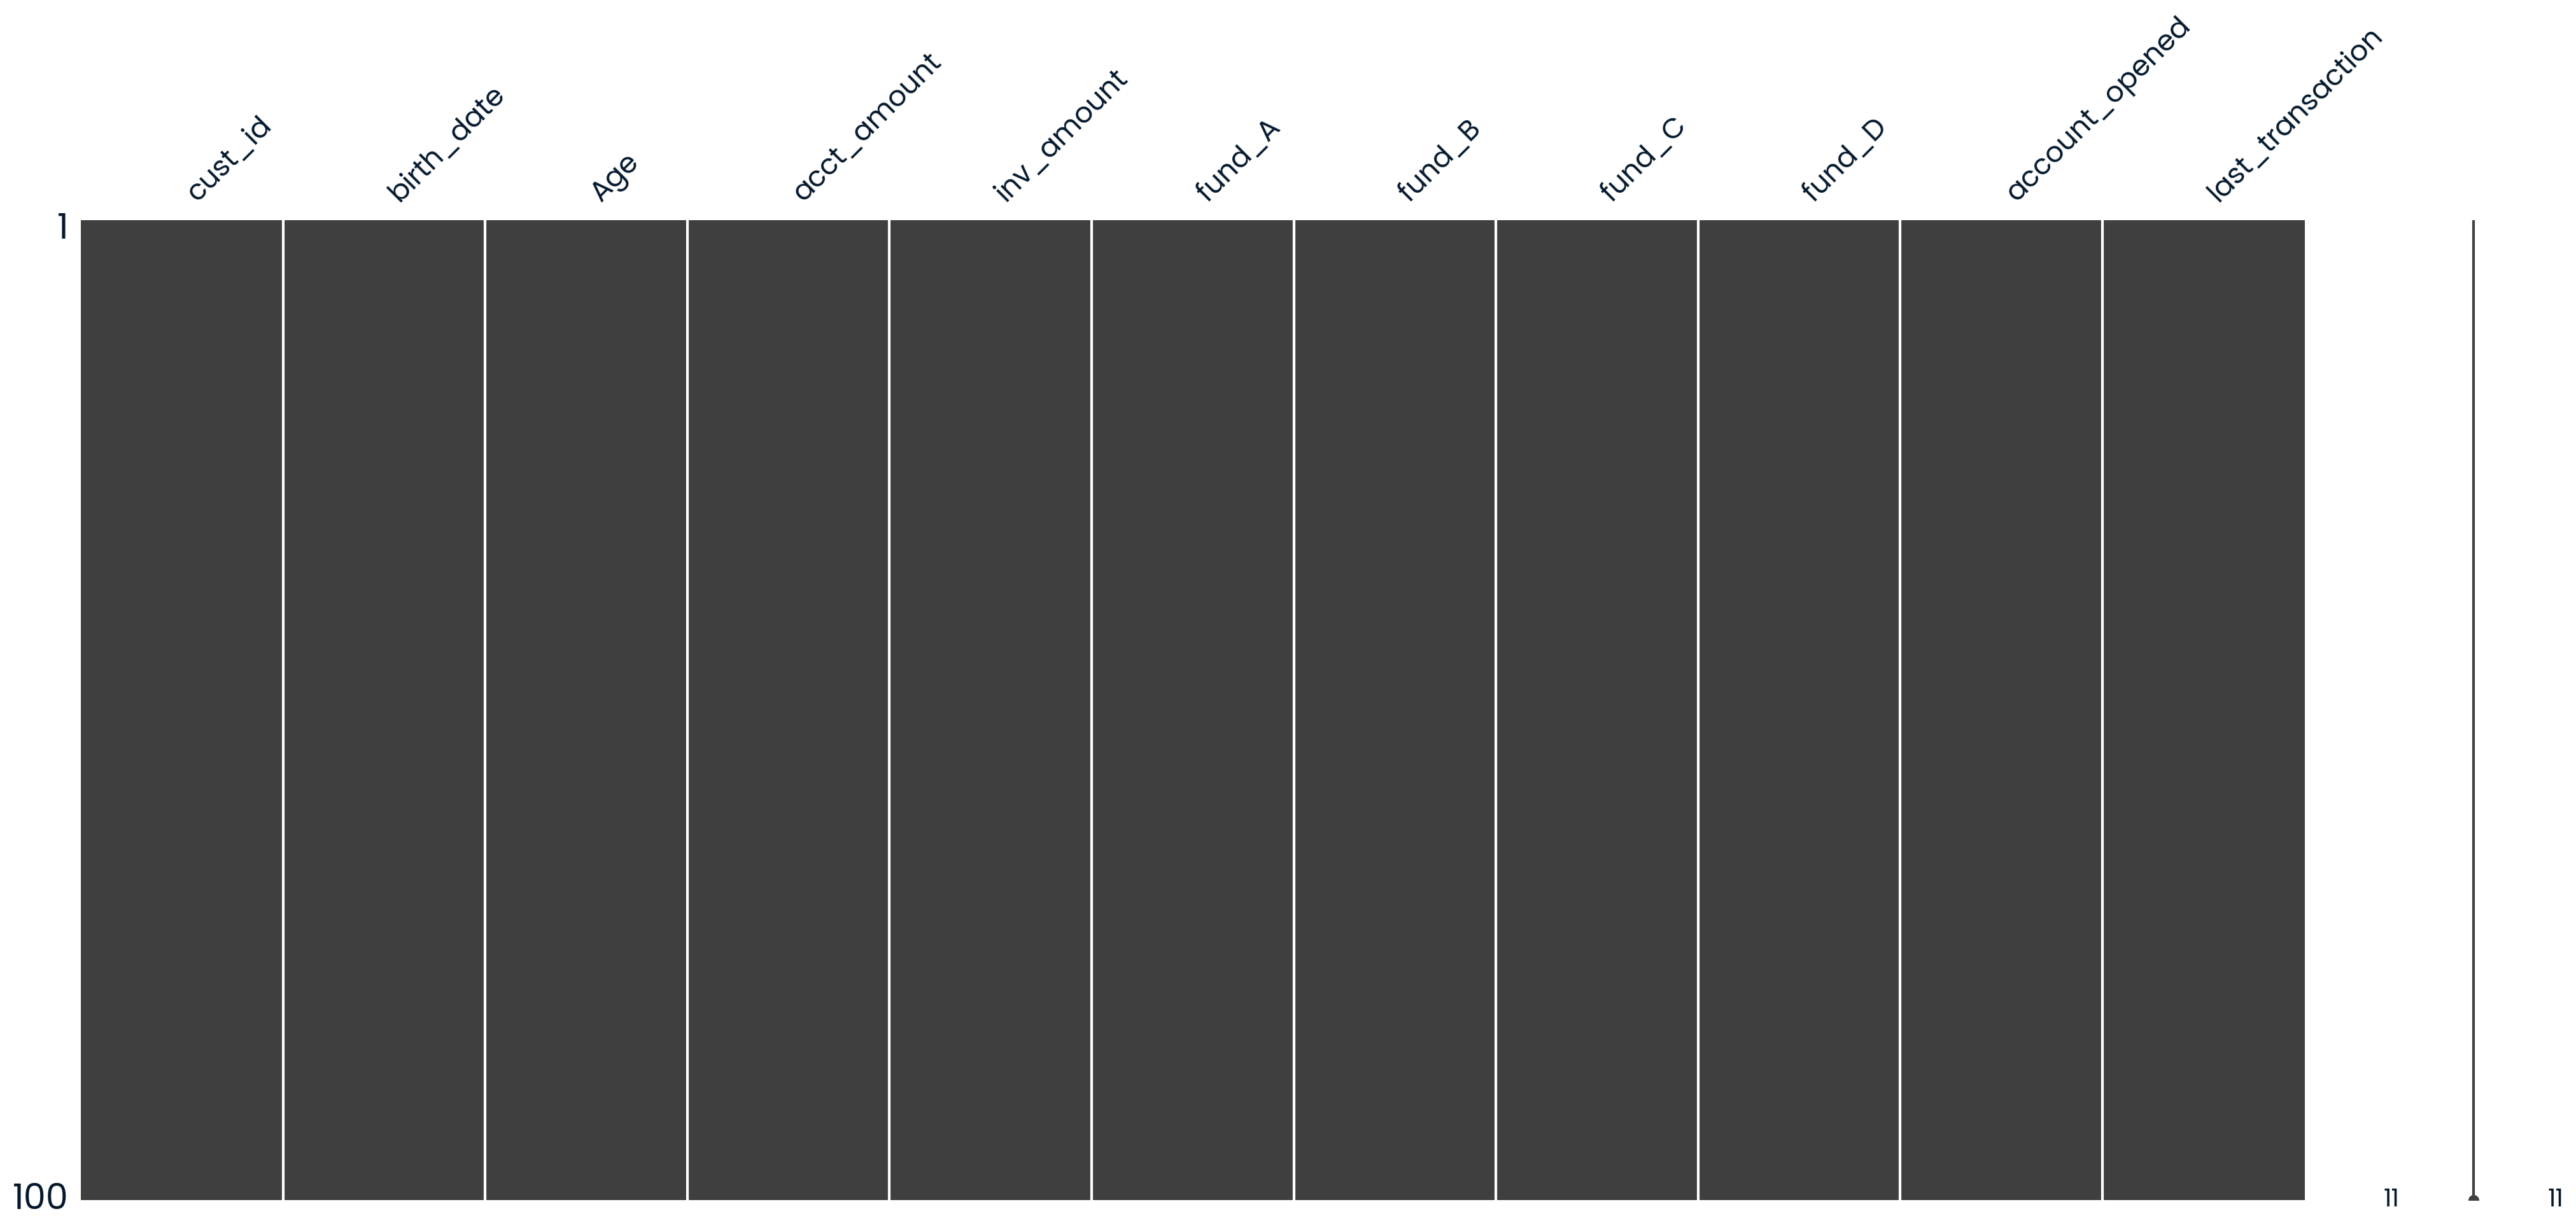

In [2]:
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

Science they provied cleaing data so we do not have any missing data.

Isolate the values of `banking` missing values of `inv_amount` into `missing_investors` and with non-missing `inv_amount` values into `investors`.

In [ ]:
# Isolate missing and non missing values of inv_amount
missing_investors = banking[banking['inv_amount'].isna()]
investors = banking[~banking['inv_amount'].isna()]

### Question
Now that you've isolated `banking` into `investors` and `missing_investors`, use the `.describe()` method on both of these DataFrames to understand whether there are structural differences between them. What do you think is going on?

**Possible answers**

- The data is missing completely at random and there are no drivers behind the missingness.
- The `inv_amount` is missing only for young customers, since the average age in `missing_investors` is 22 and the maximum age is 25.
- The `inv_amount` is missing only for old customers, since the average age in `missing_investors` is 42 and the maximum age is 59.

Answer - B

Sort the `banking` DataFrame by the `age` column and plot the missingness matrix of `banking_sorted`.

In [ ]:
# Sort banking by age and visualize
banking_sorted = banking.sort_values(by = 'age')
msno.matrix(banking_sorted)
plt.show()

### Follow the money
In this exercise, you're working with another version of the `banking` DataFrame that contains missing values for both the `cust_id` column and the `acct_amount` column.

You want to produce analysis on how many unique customers the bank has, the average amount held by customers and more. You know that rows with missing `cust_id` don't really help you, and that on average `acct_amount` is usually 5 times the amount of `inv_amount`.

In this exercise, you will drop rows of banking with missing `cust_ids`, and impute missing values of `acct_amount` with some domain knowledge.

- Use `.dropna()` to drop missing values of the `cust_id` column in banking and store the results in `banking_fullid`.
- Use `inv_amount` to compute the estimated account amounts for `banking_fullid` by setting the amounts equal to `inv_amount * 5`, and assign the results to `acct_imp`.
- Impute the missing values of `acct_amount` in `banking_fullid` with the newly created `acct_imp` using `.fillna()`.

In [ ]:
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount': acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())

## 4 Record linkage

### 4.1. Comparing strings

Welcome to the final chapter of this course,where we'll discover the world of record linkage. But before we get deep dive into record linkage, let's sharpen our understanding of string similarity and minimum edit distance.

### Minimum edit distance

Minimum edit distance is a systematic way to identify how close 2 strings are. For example, let's take a look at the following two words: intention, and execution. The minimum edit distance between them is the least possible amount of steps, that could get us from the word intention to execution, with the available operations beinginserting new characters, deleting them, substituting them, and transposing consecutive characters.

To get from intention to execution, We first start off by deleting I from intention, and adding C between E and N. Our minimum edit distance so far is 2, since these are two operations.Then we substitute the first N with E, T with X, and N with U, leading us to execution! With the minimum edit distance being 5.

The lower the edit distance, the closer two words are. For example, the two different typos of reading have a minimum edit distance of 1 between them and reading.

![reading](reading.PNG)

### Minimum edit distance algorithms

There's a variety of algorithms based on edit distance that differ on which operations they use, how much weight attributed to each operation, which type of strings they're suited for and more, with a variety of packages to get each similarity.

![algorithom](algorithom.PNG)

For this lesson, we'll be comparing strings using Levenshtein distance since it's the most general form of string matching by using the thefuzz package.

thefuzz is a package to perform string comparison. We first import fuzz from thefuzz, which allow us to compare between single strings. Here we use fuzz's WRatio function to compute the similarity between reading and its typo, inputting each string as an argument. For any comparison function using thefuzz, our output is a score from 0 to 100 with 0 being not similar at all, 100 being an exact match. Do not confuse this with the minimum edit distance score from earlier, where a lower minimum edit distance means a closer match.

In [1]:
# Lets us compare between two strings 
from thefuzz import fuzz  
# Compare reeding vs reading 
fuzz.WRatio('Reeding', 'Reading') 

86

### Partial strings and different orderings

The WRatio function is highly robust against partial string comparison with different orderings. For example here we compare the strings Houston Rockets and Rockets, and still receive a high similarity score. The same can be said for the strings Houston Rockets vs Los Angeles Lakers and Lakers vs Rockets, where the team names are only partial and they are differently ordered.

In [2]:
# Partial string comparison 
fuzz.WRatio('Houston Rockets', 'Rockets') 

90

In [3]:
# Partial string comparison with different order 
fuzz.WRatio('Houston Rockets vs Los Angeles Lakers', 'Lakers vs Rockets')

86

### Comparison with arrays

We can also compare a string with an array of strings by using the extract function from the process module from fuzzy wuzzy. Extract takes in a string, an array of strings, and the number of possible matches to return ranked from highest to lowest. It returns a list of tuples with 3 elements, the first one being the matching string being returned, the second one being its similarity score, and the third one being its index in the array.

In [5]:
# Import process 
from thefuzz import process
import pandas as pd
# Define string and array of possible matches 
string = "Houston Rockets vs Los Angeles Lakers" 
choices = pd.Series(['Rockets vs Lakers', 'Lakers vs Rockets',  
'Houson vs Los Angeles', 'Heat vs Bulls']) 
process.extract(string, choices, limit = 2) 

[('Rockets vs Lakers', 86, 0), ('Lakers vs Rockets', 86, 1)]

### Collapsing categories with string similarity

In chapter 2, we learned that collapsing data into categories is an essential aspect of working with categorical and text data, and we saw how to manually replace categories in a column of a DataFrame. But what if we had so many inconsistent categories that a manual replacement is simply not feasible? We can easily do that with string similarity!

Say we have DataFrame named survey containing answers from respondents from the state of New York and California asking them how likely are you to move on a scale of 0 to 5. The state field was free text and contains hundreds of typos. Remapping them manually would take a huge amount of time.

Instead, we'll use string similarity. We also have a category DataFrame containing the correct categories for each state. Let's collapse the incorrect categories with string matching!

In [ ]:
print(survey['state'].unique())
categories

![survey data](survey%20data.PNG)

### Collapsing all of the state

In [ ]:
 # For each correct category 
for state in categories['state']:  
  # Find potential matches in states with typoes 
    matches = process.extract(state, survey['state'], limit = survey.shape[0])  
    # For each potential match match 
    for potential_match in matches: 
       # If high similarity score 
        if potential_match[1] >= 80:  
          # Replace typo with correct category 
          survey.loc[survey['state'] == potential_match[0], 'state'] = state

### Record linkage

Record linkage attempts to join data sources that have similarly fuzzy duplicate values, so that we end up with a final DataFrame with no duplicates by using string similarity. We'll cover record linkage in more detail in the next couple of lessons.

Record linkage (also called data matching or entity resolution) is a way to combine records from two or more datasets that refer to the same real-world entity (like a person, place, or business), even if the names or values are not exactly the same.

![record linkage](record%20linkage.PNG)

### Exercise
### Minimum edit distance
In the video exercise, you saw how minimum edit distance is used to identify how similar two strings are. As a reminder, minimum edit distance is the minimum number of steps needed to reach from String A to String B, with the operations available being:

- Insertion of a new character.
- Deletion of an existing character.
- Substitution of an existing character.
- Transposition of two existing consecutive characters.

_What is the minimum edit distance from 'sign' to 'sing', and which operation(s) gets you there?_

Possible Answers - Select one answer

- 2 by substituting 'g' with 'n' and 'n' with 'g'.
- 1 by transposing 'g' with 'n'.
- 1 by substituting 'g' with 'n'.
- 2 by deleting 'g' and inserting a new 'g' at the end.

### The cutoff point
In this exercise, and throughout this chapter, you'll be working with the `restaurants` DataFrame which has data on various restaurants. Your ultimate goal is to create a restaurant recommendation engine, but you need to first clean your data.

This version of `restaurants` has been collected from many sources, where the `cuisine_type` column is riddled with typos, and should contain only `italian`, `american` and `asian` cuisine types. There are so many unique categories that remapping them manually isn't scalable, and it's best to use string similarity instead.

Before doing so, you want to establish the cutoff point for the similarity score using the thefuzz's `process.extract()` function by finding the similarity score of the most distant typo of each category.

- Import `process` from `thefuzz`.
- Store the `unique cuisine_types` into `unique_types`.
- Calculate the similarity of `'asian', 'american'`, and `'italian'` to all possible `cuisine_types` using` process.extract()`, while returning all possible matches.

In [ ]:
# Import process from thefuzz
from thefuzz import process

# Store the unique values of cuisine_type in unique_types
unique_types = restaurants['cuisine_type'].unique()

# Calculate similarity of 'asian' to all values of unique_types
print(process.extract('asian', unique_types, limit = len(unique_types)))

# Calculate similarity of 'american' to all values of unique_types
print(process.extract('american', unique_types, limit = len(unique_types)))

# Calculate similarity of 'italian' to all values of unique_types
print(process.extract('italian', unique_types, limit = len(unique_types)))

Question

**Take a look at the output, what do you think should be the similarity cutoff point when remapping categories?**

Possible answers
- 80
- 70
- 60

### Remapping categories II
In the last exercise, you determined that the distance cutoff point for remapping typos of `'american', 'asian'`, and `'italian'` cuisine types stored in the `cuisine_type` column should be 80.

In this exercise, you're going to put it all together by finding matches with similarity scores equal to or higher than 80 by using `fuzywuzzy.process`'s `extract()` function, for each correct cuisine type, and replacing these matches with it. Remember, when comparing a string with an array of strings using `process.extract()`, the output is a list of tuples where each is formatted like:

`(closest match, similarity score, index of match)`

The `restaurants` DataFrame is in your environment, and you have access to a categories list containing the correct cuisine types (`'italian', 'asian'`, and `'american'`).

In [ ]:
# Inspect the unique values of the cuisine_type column
print(restaurants['cuisine_type'].unique())

# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'], limit = restaurants.shape[0])

# Inspect the first 5 matches
print(matches[0:5])

# Create a list of matches, comparing 'italian' with the cuisine_type column
matches = process.extract('italian', restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))

# Iterate through the list of matches to italian
for match in matches:
  # Check whether the similarity score is greater than or equal to 80
  if match[1] >= 80:
    # Select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
    restaurants.loc[restaurants['cuisine_type'] == match[0], 'cuisine_type'] = 'italian'

Remapping all categories

In [ ]:
# Iterate through categories
for cuisine in categories:  
  # Create a list of matches, comparing cuisine with the cuisine_type column
  matches = process.extract(cuisine, restaurants['cuisine_type'], limit=len(restaurants.cuisine_type))

  # Iterate through the list of matches
  for match in matches:
     # Check whether the similarity score is greater than or equal to 80
    if match[1] >= 80:
      # If it is, select all rows where the cuisine_type is spelled this way, and set them to the correct cuisine
      restaurants.loc[restaurants['cuisine_type'] == match[0]] = cuisine
      
# Inspect the final result
print(restaurants['cuisine_type'].unique())

### 4.2 Generating pairs

Great work with lesson 1 - you now have a solid understanding how to calculate string similarity.

At the end of the last video exercise, we saw how record linkage attempts to join data sources with fuzzy duplicate values. For example here are two DataFrames containing NBA games and their schedules. They've both been scraped from different sites and we would want to merge them together and have one DataFrame containing all unique games.

![event](event.PNG)

We see that there are duplicates values in both DataFrames with different naming marked here in black, and non duplicate values, marked here in green. Since there are games happening at the same time, no common unique identifier between the DataFrames, and the events are differently named, a regular join or merge will not work. This is where record linkage comes in.

![recoreing](recoreing.PNG)

Record linkage is the act of linking data from different sources regarding the same entity. Generally, we clean two or more DataFrames, generate pairs of potentially matching records, score these pairs according to string similarity and other similarity metrics, and link them. All of these steps can be achieved with the recordlinkage package, let's find how!

![linkage](linkage.PNG)

Here we have two DataFrames, census_A, and census_B, containing data on individuals throughout the states. We want to merge them while avoiding duplication using record linkage, since they are collected manually and are prone to typos, there are no consistent IDs between them.

![data census](data%20census.PNG)

We first want to generate pairs between both DataFrames. Ideally, we want to generate all possible pairs between our DataFrames.

![similar pair](similar%20pair.PNG)

but what if we had big DataFrames and ended up having to generate millions if not billions of pairs? It wouldn't prove scalable and could seriously hamper development time.

![milion pair](milion%20pair.PNG)

### Blocking

This is where we apply what we call blocking, which creates pairs based on a matching column, which is in this case, the state column, reducing the number of possible pairs.

### Generating pairs

To do this, we first start off by importing recordlinkage. We then use the recordlinkage dot Index function, to create an indexing object. This essentially is an object we can use to generate pairs from our DataFrames. To generate pairs blocked on state, we use the block method, inputting the state column as input. Once the indexer object has been initialized, we generate our pairs using the dot index method, which takes in the two dataframes.

In [ ]:
# Import recordlinkage 
import recordlinkage  
# Create indexing object 
indexer = recordlinkage.Index() 
# Generate pairs blocked on state 
indexer.block('state') 
pairs = indexer.index(census_A, census_B)

The resulting object, is a pandas multi index object containing pairs of row indices from both DataFrames, which is a fancy way to say it is an array containing possible pairs of indices that makes it much easier to subset DataFrames on.

![generating pair](generating%20pair.PNG)

### Comparing the DataFrames

Since we've already generated our pairs, it's time to find potential matches. We first start by creating a comparison object using the recordlinkage dot compare function. This is similar to the indexing object we created while generating pairs, but this one is responsible for assigning different comparison procedures for pairs. Let's say there are columns for which we want exact matches between the pairs. To do that, we use the exact method. It takes in the column name in question for each DataFrame, which is in this case date_of_birth and state, and a label argument which lets us set the column name in the resulting DataFrame. Now in order to compute string similarities between pairs of rows for columns that have fuzzy values, we use the dot string method, which also takes in the column names in question, the similarity cutoff point in the threshold argument, which takes in a value between 0 and 1, which we here set to 0.85. Finally to compute the matches, we use the compute function, which takes in the possible pairs, and the two DataFrames in question. Note that you need to always have the same order of DataFrames when inserting them as arguments when generating pairs, comparing between columns, and computing comparisons.

In [ ]:
 # Generate the pairs 
pairs = indexer.index(census_A, census_B) 
# Create a Compare object 
compare_cl = recordlinkage.Compare() 
# Find exact matches for pairs of date_of_birth and state 
compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth') 
compare_cl.exact('state', 'state', label='state')  
# Find similar matches for pairs of surname and address_1 using string similarity 
compare_cl.string('surname', 'surname', threshold=0.85, label='surname') 
compare_cl.string('address_1', 'address_1', threshold=0.85, label='address_1')  
# Find matches 
potential_matches = compare_cl.compute(pairs, census_A, census_B) 

The output is a multi index DataFrame, where the first index is the row index from the first DataFrame, or census A, and the second index is a list of all row indices in census B. The columns are the columns being compared, with values being 1 for a match, and 0 for not a match.

![compare output](compare%20output.PNG)

To find potential matches, we just filter for rows where the sum of row values is higher than a certain threshold. Which in this case higher or equal to 2. But we'll dig deeper into these matches and see how to use them to link our census DataFrames in the next lesson.

In [ ]:
 potential_matches[potential_matches.sum(axis = 1) => 2] 

![threshold](threshold.PNG)

### Excerice

### Pairs of restaurants
In the last lesson, you cleaned the restaurants dataset to make it ready for building a restaurants recommendation engine. You have a new DataFrame named `restaurants_new` with new restaurants to train your model on, that's been scraped from a new data source.

You've already cleaned the `cuisine_type` and `city` columns using the techniques learned throughout the course. However you saw duplicates with typos in restaurants names that require record linkage instead of joins with restaurants.

In this exercise, you will perform the first step in record linkage and generate possible pairs of rows between `restaurants` and `restaurants_new`. Both DataFrames, `pandas` and `recordlinkage` are in your environment.

- Instantiate an indexing object by using the `Index()` function from `recordlinkage`.
- Block your pairing on `cuisine_type` by using `indexer`'s' `.block()` method.
- Generate pairs by indexing `restaurants` and `restaurants_new` in that order.

In [ ]:
# Create an indexer and object and find possible pairs
indexer = recordlinkage.Index()

# Block pairing on cuisine_type
indexer.block('cuisine_type')

# Generate pairs
pairs = indexer.index(restaurants, restaurants_new)

**Question**

**Now that you've generated your pairs, you've achieved the first step of record linkage. What are the steps remaining to link both restaurants DataFrames, and in what order?**

_Possible answers_


- Compare between columns, score the comparison, then link the DataFrames.
- Clean the data, compare between columns, link the DataFrames, then score the comparison.
- Clean the data, compare between columns, score the comparison, then link the DataFrames.

### Similar restaurants
In the last exercise, you generated pairs between `restaurants` and `restaurants_new` in an effort to cleanly merge both DataFrames using record linkage.

When performing record linkage, there are different types of matching you can perform between different columns of your DataFrames, including exact matches, string similarities, and more.

Now that your pairs have been generated and stored in `pairs`, you will find exact matches in the `city` and `cuisine_type` columns between each pair, and similar strings for each pair in the `rest_name` column. Both DataFrames, pandas and recordlinkage are in your environment.

In [ ]:
# Create a comparison object
comp_cl = recordlinkage.Compare()

# Find exact matches on city, cuisine_types 
comp_cl.exact('city', 'city', label='city')
comp_cl.exact('cuisine_type', 'cuisine_type', label = 'cuisine_type')

# Find similar matches of rest_name
comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# Get potential matches and print
potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
print(potential_matches)

In [ ]:
        city  cuisine_type  name
0   0      0             1   0.0
    1      0             1   0.0
    7      0             1   0.0
    12     0             1   0.0
    13     0             1   0.0
...      ...           ...   ...
40  18     0             1   0.0
281 18     0             1   0.0
288 18     0             1   0.0
302 18     0             1   0.0
308 18     0             1   0.0

Print out `potential_matches`, the columns are the columns being compared, with values being 1 for a match, and 0 for not a match for each pair of rows in your DataFrames. To find potential matches, you need to find rows with more than matching value in a column. You can find them with

`potential_matches[potential_matches.sum(axis = 1) >= n]`

_Where n is the minimum number of columns you want matching to ensure a proper duplicate find, what do you think should the value of n be?_

Possible answers

- 3 because I need to have matches in all my columns.
- 2 because matching on any of the 2 columns or more is enough to find potential duplicates.
- 1 because matching on just 1 column like the restaurant name is enough to find potential duplicates.

Ans - A

## 4. Linking DataFrames

At this point, you've generated your pairs, compared them, and scored them.Now it's time to link our data!
![image-1](image-1.png)

Remember our census DataFrames from the video of the previous lesson?
![image-2](image-2.png)

We've already generated pairs between them, compared four of their columns, two for exact matches and two for string similarity alongside a 0.85 threshold, and found potential matches.

In [ ]:
# Import recordlinkage and generate full pairs 
import recordlinkage 
indexer = recordlinkage.Index() 
indexer.block('state') 
full_pairs = indexer.index(census_A, census_B) 
# Comparison step 
compare_cl = recordlinkage.Compare() 
compare_cl.exact('date_of_birth', 'date_of_birth', label='date_of_birth') 
compare_cl.exact('state', 'state', label='state') 
compare_cl.string('surname', 'surname', threshold=0.85, label='surname') 
compare_cl.string('address_1', 'address_1', threshold=0.85, label='address_1') 
potential_matches = compare_cl.compute(full_pairs, census_A, census_B) 

Now it's time to link both census DataFrames.
![image-4](image-4.png)

Let's look closely at our potential matches. It is a multi-index DataFrame, where we have two index columns, record id 1, and record id 2.
![image-5](image-5.png)

The first index column, stores indices from census A.The second index column, stores all possible indices from census_B, for each row index of census_A.The columns of our potential matches are the columns we chose to link both DataFrames on, where the value is 1 for a match, and 0 otherwise.
![image-7](image-7.png)

The first step in linking DataFrames, is to isolate the potentially matching pairs to the ones we're pretty sure of. We saw how to do this in the previous lesson, by subsetting the rows where the row sum is above a certain number of columns, in this case 3. The output is row indices between census A and census B that are most likely duplicates. Our next step is to extract the one of the index columns, and subsetting its associated DataFrame to filter for duplicates.

In [ ]:
matches = potential_matches[potential_matches.sum(axis = 1) >= 3] 
print(matches)

Here we choose the second index column, which represents row indices of census B. We want to extract those indices, and subset census_B on them to remove duplicates with census_A before appending them together.
![image-8](image-8.png)

We can access a DataFrame's index using the index attribute. Since this is a multi index DataFrame, it returns a multi index object containing pairs of row indices from census_A and census_B respectively.

In [ ]:
 matches.index

Output

In [ ]:
MultiIndex(levels=[['rec-1007-org', 'rec-1016-org', 'rec-1054-org', 'rec-1066-org',  
'rec-1070-org', 'rec-1075-org', 'rec-1080-org', 'rec-110-org', ... 

We want to extract all census_B indices, so we chain it with the `get_level_values` method, which takes in which column index we want to extract its values. We can either input the index column's name, or its order, which is in this case 1.

In [ ]:
# Get indices from census_B only 
duplicate_rows = matches.index.get_level_values(1) 
print(census_B_index) 

In [ ]:
Index(['rec-2404-dup-0', 'rec-4178-dup-0', 'rec-1054-dup-0', 'rec-4663-dup-0', 
'rec-485-dup-0', 'rec-2950-dup-0', 'rec-1234-dup-0', ... , 'rec-299-dup-0']) 

To find the duplicates in `census B`, we simply subset on all indices of `census_B`, with the ones found through record linkage. You can choose to examine them further for similarity with their duplicates in census_A, but if you're sure of your analysis, you can go ahead and find the non duplicates by repeating the exact same line of code, except by adding a tilde at the beginning of your subset. Now that you have your non duplicates, all you need is a simple append using the DataFrame append method of census A, and you have your linked Data!

In [ ]:
# Finding duplicates in census_B 
census_B_duplicates = census_B[census_B.index.isin(duplicate_rows)] 
# Finding new rows in census_B 
census_B_new = census_B[~census_B.index.isin(duplicate_rows)] 
# Link the DataFrames! 
full_census = census_A.append(census_B_new) 

To recap, what we did was build on top of our previous work in generating pairs, comparing across columns and finding potential matches. We then isolated all possible matches, where there are matches across 3 columns or more, ensuring we tightened our search for duplicates across both DataFrames before we link them. Extracted the row indices of census_B where there are duplicates. Found rows of census_B where they are not duplicated with census_A by using the tilde symbol. And linked both DataFrames for full census results!

In [ ]:
# Import recordlinkage and generate pairs and compare across columns 
... 
# Generate potential matches
 potential_matches = compare_cl.compute(full_pairs, census_A, census_B) 
# Isolate matches with matching values for 3 or more columns
 matches = potential_matches[potential_matches.sum(axis = 1) >= 3] 
# Get index for matching census_B rows only 
duplicate_rows = matches.index.get_level_values(1) 
# Finding new rows in census_B 
census_B_new = census_B[~census_B.index.isin(duplicate_rows)] 
# Link the DataFrames! 
full_census = census_A.append(census_B_new)

### Exercise-

### Getting the right index
Here's a DataFrame named `matches` containing potential matches between two DataFrames, `users_1` and `users_2`. Each DataFrame's row indices is stored in `uid_1` and `uid_2` respectively.

In [ ]:
                   first_name  address_1  address_2  marriage_status  date_of_birth
uid_1 uid_2                                                                  
0     3              1          1          1                1              0
     ...            ...         ...        ...              ...            ...
     ...            ...         ...        ...              ...            ...
1     3              1          1          1                1              0
     ...            ...         ...        ...              ...            ...
     ...            ...         ...        ...              ...            ...

### Q - How do you extract all values of the `uid_1` index column?

### Possible Answers
Select one answer

- `matches.index.get_level_values(0)`
- `matches.index.get_level_values(1)`
- `matches.index.get_level_values('uid_1')`
- `Both 1 and 3 are correct.`

### Linking them together!
In the last lesson, you've finished the bulk of the work on your effort to link `restaurants` and `restaurants_new`. You've generated the different pairs of potentially matching rows, searched for exact matches between the `cuisine_type` and `city` columns, but compared for similar strings in the `rest_name` column. You stored the DataFrame containing the scores in `potential_matches`.

Now it's finally time to link both DataFrames. You will do so by first extracting all row indices of `restaurants_new` that are matching across the columns mentioned above from `potential_matches`. Then you will subset `restaurants_new` on these indices, then append the non-duplicate values to restaurants. All DataFrames are in your environment, alongside `pandas imported as pd`.

In [ ]:
# Isolate potential matches with row sum >=3
matches = potential_matches[potential_matches.sum(axis = 1) >= 3]

# Get values of second column index of matches
matching_indices = matches.index.get_level_values(1)

# Subset restaurants_new based on non-duplicate values
non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# Append non_dup to restaurants
full_restaurants = restaurants.append(non_dup)
print(full_restaurants)

In [ ]:
                    rest_name                  rest_addr               city       phone cuisine_type
0   arnie morton's of chicago   435 s. la cienega blv .         los angeles  3102461501     american
1          art's delicatessen       12224 ventura blvd.         studio city  8187621221     american
2                   campanile       624 s. la brea ave.         los angeles  2139381447     american
3                       fenix    8358 sunset blvd. west           hollywood  2138486677     american
4          grill on the alley           9560 dayton way         los angeles  3102760615     american
..                        ...                        ...                ...         ...          ...
76                        don        1136 westwood blvd.           westwood  3102091422      italian
77                      feast        1949 westwood blvd.            west la  3104750400      chinese
78                   mulberry        17040 ventura blvd.             encino  8189068881        pizza
80                    jiraffe      502 santa monica blvd       santa monica  3109176671  californian
81                   martha's  22nd street grill 25 22nd  st. hermosa beach  3103767786     american
